## **Introduction**

This project focuses on traffic sign classification using the German Traffic Sign Recognition Benchmark (GTSRB). We implemented and compared deep learning models like CNN and VGG16 to classify 43 traffic sign categories, utilizing data augmentation and performance metrics such as accuracy and loss graphs, confusion matrices for evaluation.








In [ ]:
!nvidia-smi

Sat Dec 21 22:27:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0              29W /  70W |    359MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
#Checking GPU availability
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Is GPU Available?: ", tf.test.is_gpu_available())

Num GPUs Available:  1
Is GPU Available?:  True


In [ ]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import os
import pathlib
import random as rn
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from sklearn.metrics import accuracy_score
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [1]:
#Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Dataset**

The German Traffic Sign Recognition Benchmark (GTSRB) is a widely-used dataset for evaluating models in traffic sign classification. It contains over 50,000 images across 43 classes, including various traffic signs seen in real-world scenarios. The dataset challenges models with diverse lighting conditions, occlusions, and varying resolutions, making it a benchmark for assessing classification performance

Dataset Link : https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

In [ ]:
data_dir = '/content/drive/MyDrive/GermanTrafficSigns/'
train_path = '/content/drive/MyDrive/GermanTrafficSigns/Train/'
test_path = '/content/drive/MyDrive/GermanTrafficSigns/Test/'
height = 50
width = 50

## **Defining all 43 classes**

In [8]:
#43 classes of dataset
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

In [ ]:
batch_size = 150
seed = 42

## **Spliting the Dataset into Train and Test**

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)
#Spliting dataset into train_dataset
train_dataset = train_datagen.flow_from_directory(train_path,
                                                  target_size=(height, width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=seed,
                                                  color_mode='rgb',
                                                  interpolation='hamming',
                                                  subset='training')

test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.2)
#Spliting dataset into test_dataset
test_dataset = test_datagen.flow_from_directory(train_path,
                                                target_size=(height, width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                seed=seed,
                                                color_mode='rgb',
                                                interpolation='hamming',
                                                subset='validation')

Found 30385 images belonging to 43 classes.
Found 7592 images belonging to 43 classes.


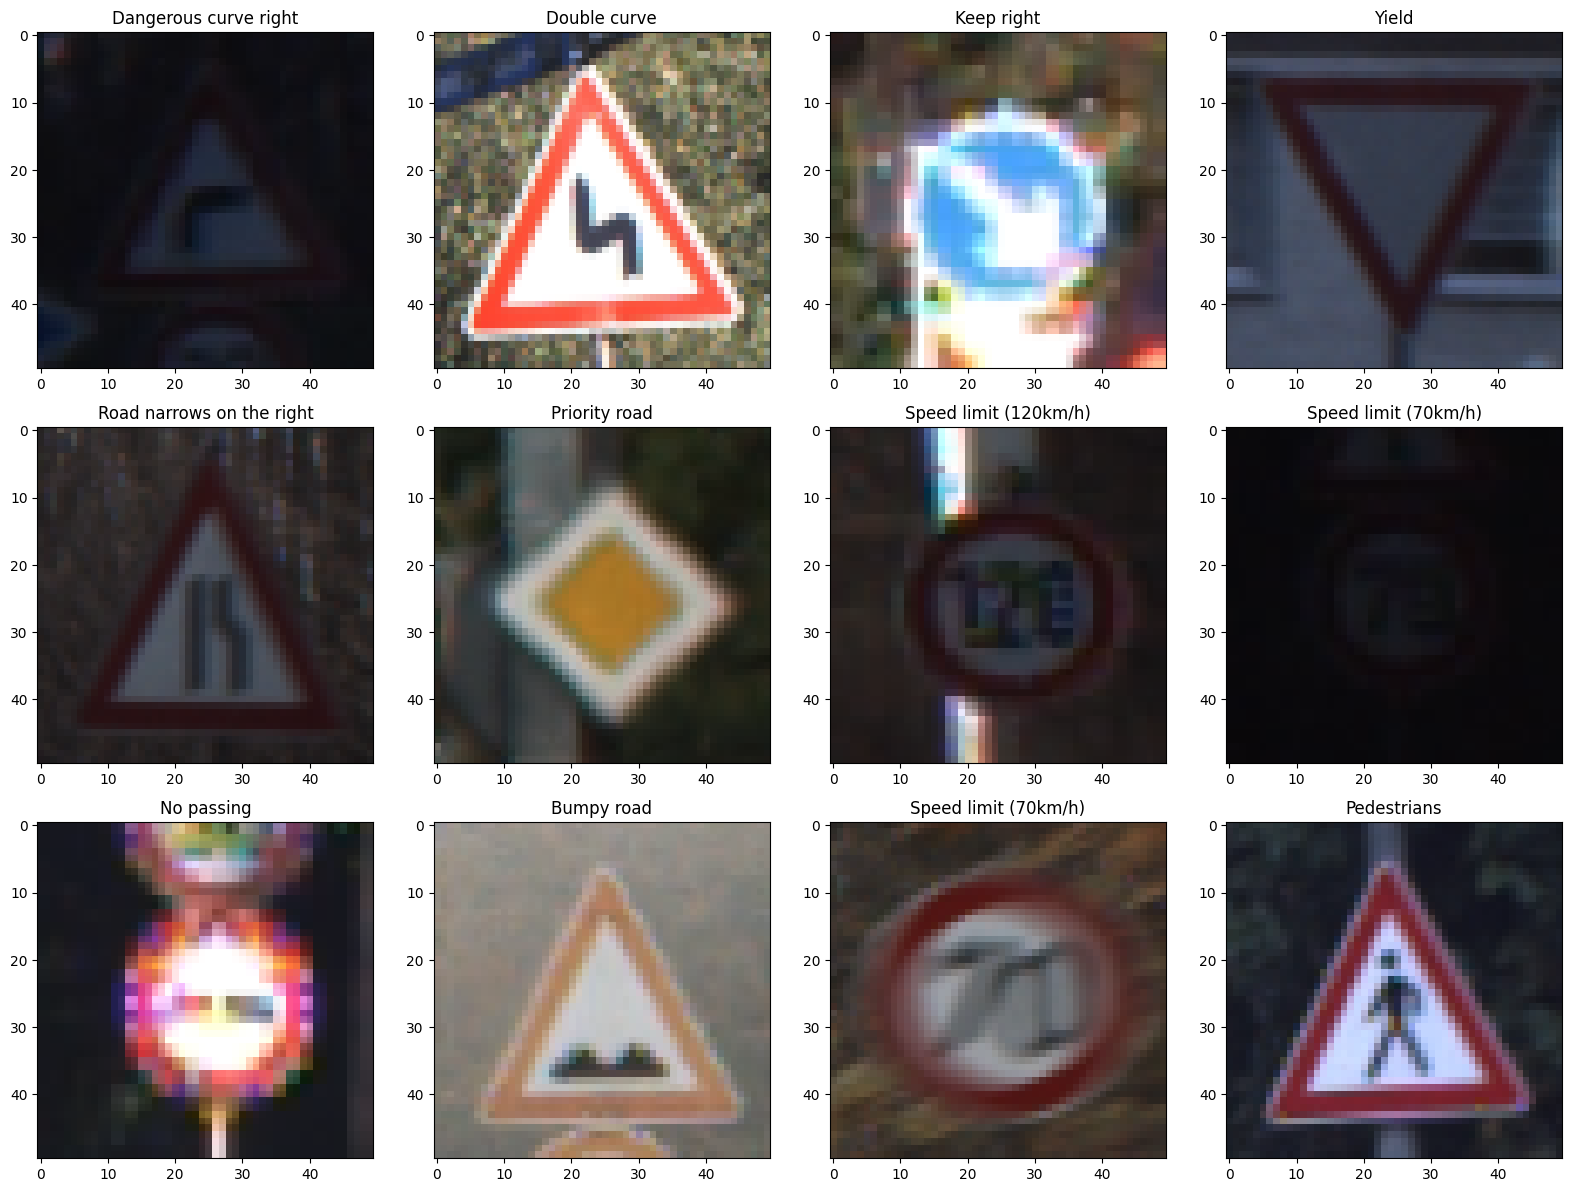

In [ ]:
#Printing Dataset Images
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
img,y = next(train_dataset)
for i in range(3):
    for j in range (4):
        l=rn.randint(0,batch_size-1)
        label = classes[int(list(train_dataset.class_indices.keys())[np.argmax(y[l])])]
        ax[i,j].imshow(img[l])
        ax[i,j].set_title(label)

plt.tight_layout()

## **Constructing the CNN Model**

In [ ]:
#Building CNN model with RELU activation function
model = keras.models.Sequential([
    keras.layers.Input(shape=(height, width, 3)),
    keras.layers.Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=(height,width,3)),
    keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(rate=0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.25),

    keras.layers.Dense(43, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary() #model layers and their shape

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 16)          │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 42, 42, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 21, 21, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 21, 21, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 19, 19, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 17, 17, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,191,627 (8.36 MB)

 Trainable params: 2,190,411 (8.36 MB)

 Non-trainable params: 1,216 (4.75 KB)

## **Compile the CNN model**

In [ ]:
#Compiling the model
alpha=0.01
epochs=15
optim = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

## **Fitting the CNN Model**

In [ ]:
history = model.fit(train_dataset,
                    steps_per_epoch=train_dataset.samples // batch_size,
                    epochs=epochs,
                    validation_data=test_dataset,
                    validation_steps=train_dataset.samples // batch_size
                    )

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


202/202 ━━━━━━━━━━━━━━━━━━━━ 8374s 40s/step - accuracy: 0.6234 - loss: 1.6761 - val_accuracy: 0.8526 - val_loss: 0.5521
Epoch 2/15
  1/202 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9533 - loss: 0.1287

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


202/202 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - accuracy: 0.9533 - loss: 0.1287 - val_accuracy: 0.8734 - val_loss: 0.4783
Epoch 3/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 90s 435ms/step - accuracy: 0.9771 - loss: 0.0782 - val_accuracy: 0.8805 - val_loss: 0.5394
Epoch 4/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - accuracy: 0.9933 - loss: 0.0162 - val_accuracy: 0.8131 - val_loss: 0.7620
Epoch 5/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 88s 426ms/step - accuracy: 0.9863 - loss: 0.0438 - val_accuracy: 0.8737 - val_loss: 0.6241
Epoch 6/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 18s 88ms/step - accuracy: 0.9733 - loss: 0.0866 - val_accuracy: 0.8775 - val_loss: 0.6314
Epoch 7/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 89s 429ms/step - accuracy: 0.9871 - loss: 0.0415 - val_accuracy: 0.9170 - val_loss: 0.3801
Epoch 8/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 18s 88ms/step - accuracy: 1.0000 - loss: 0.0116 - val_accuracy: 0.9241 - val_loss: 0.3594
Epoch 9/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 89s 431ms/step - accuracy: 0.9894 - loss: 0.0361 - val_acc

In [ ]:
model.save('cnn_model.keras')

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('cnn_model.keras')  # Load the saved model

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


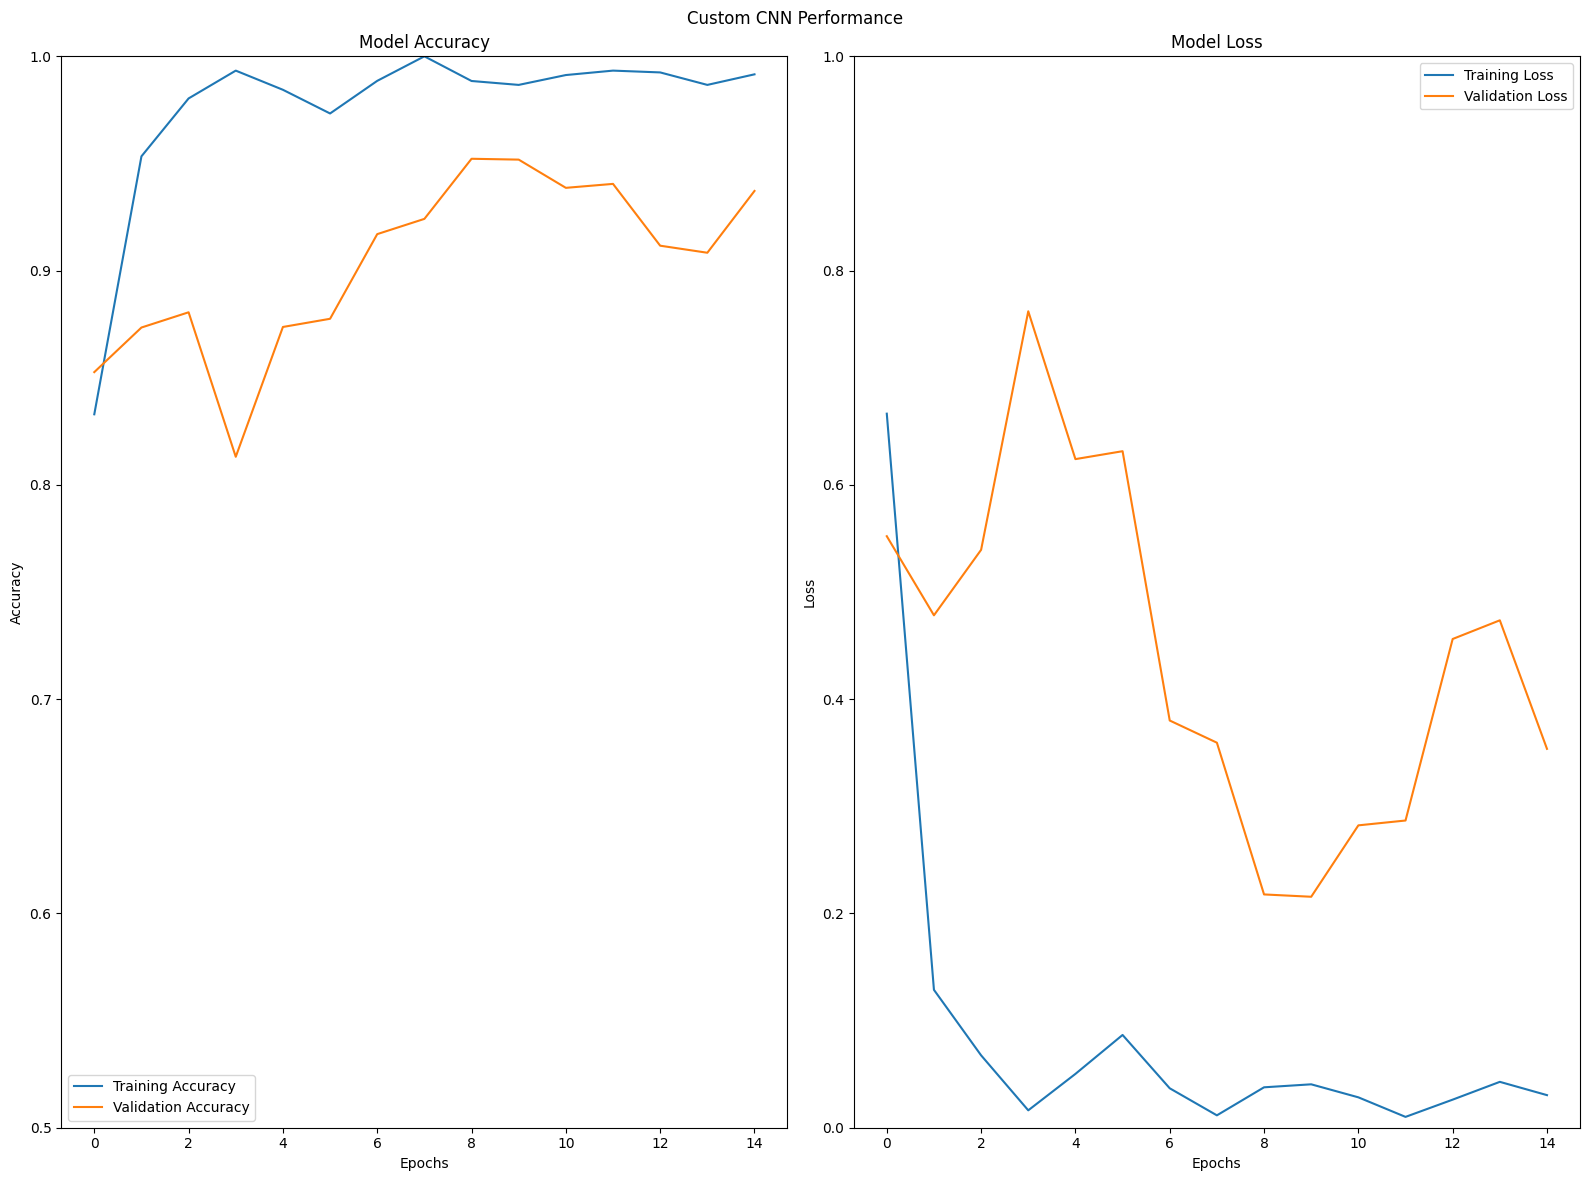

In [ ]:
# Create a figure with two subplots
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 12))

# Plot Accuracy
ax0.plot(history.history['accuracy'], label='Training Accuracy')
ax0.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax0.set_title('Model Accuracy')
ax0.set_xlabel('Epochs')
ax0.set_ylabel('Accuracy')
ax0.set_ylim(0.5, 1)
ax0.legend()

# Plot Loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_ylim(0, 1)
ax1.legend()

# Overall figure title
fig.suptitle('Custom CNN Performance')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

The CNN model achieved excellent performance on the GTSRB dataset, with training accuracy reaching 99.15% and validation accuracy stabilizing at 95.22%. The training loss dropped to 0.0297, and validation loss reached 0.3536. While the model generalizes well, slight fluctuations in validation loss suggest minor overfitting, which could be mitigated with additional regularization or data augmentation.

In [ ]:
train_score = model.evaluate(train_dataset, verbose= 1)
valid_score = model.evaluate(test_dataset, verbose= 1)
#Printing the Train and Validation scores
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])

203/203 ━━━━━━━━━━━━━━━━━━━━ 72s 354ms/step - accuracy: 0.9916 - loss: 0.0296
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 343ms/step - accuracy: 0.9379 - loss: 0.3407
Train Loss:  0.030162159353494644
Train Accuracy:  0.9912785887718201
--------------------
Validation Loss:  0.3536178171634674
Validation Accuracy:  0.9371789693832397


## **Save the CNN Model**

In [ ]:
model.save("CnnModel.h5")

In [ ]:
def map_pred(pred):
    return [int(list(train_dataset.class_indices.keys())[i]) for i in pred]
test_df = pd.read_csv(data_dir + 'Test.csv')

test_labels = test_df["ClassId"].values
imgs = test_df["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((height, width))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

In [ ]:
#Printing the Test Data Accuracy
from sklearn.metrics import accuracy_score
pred = model.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Test Data accuracy:  75.77197149643705


## **Confusion Matrix**

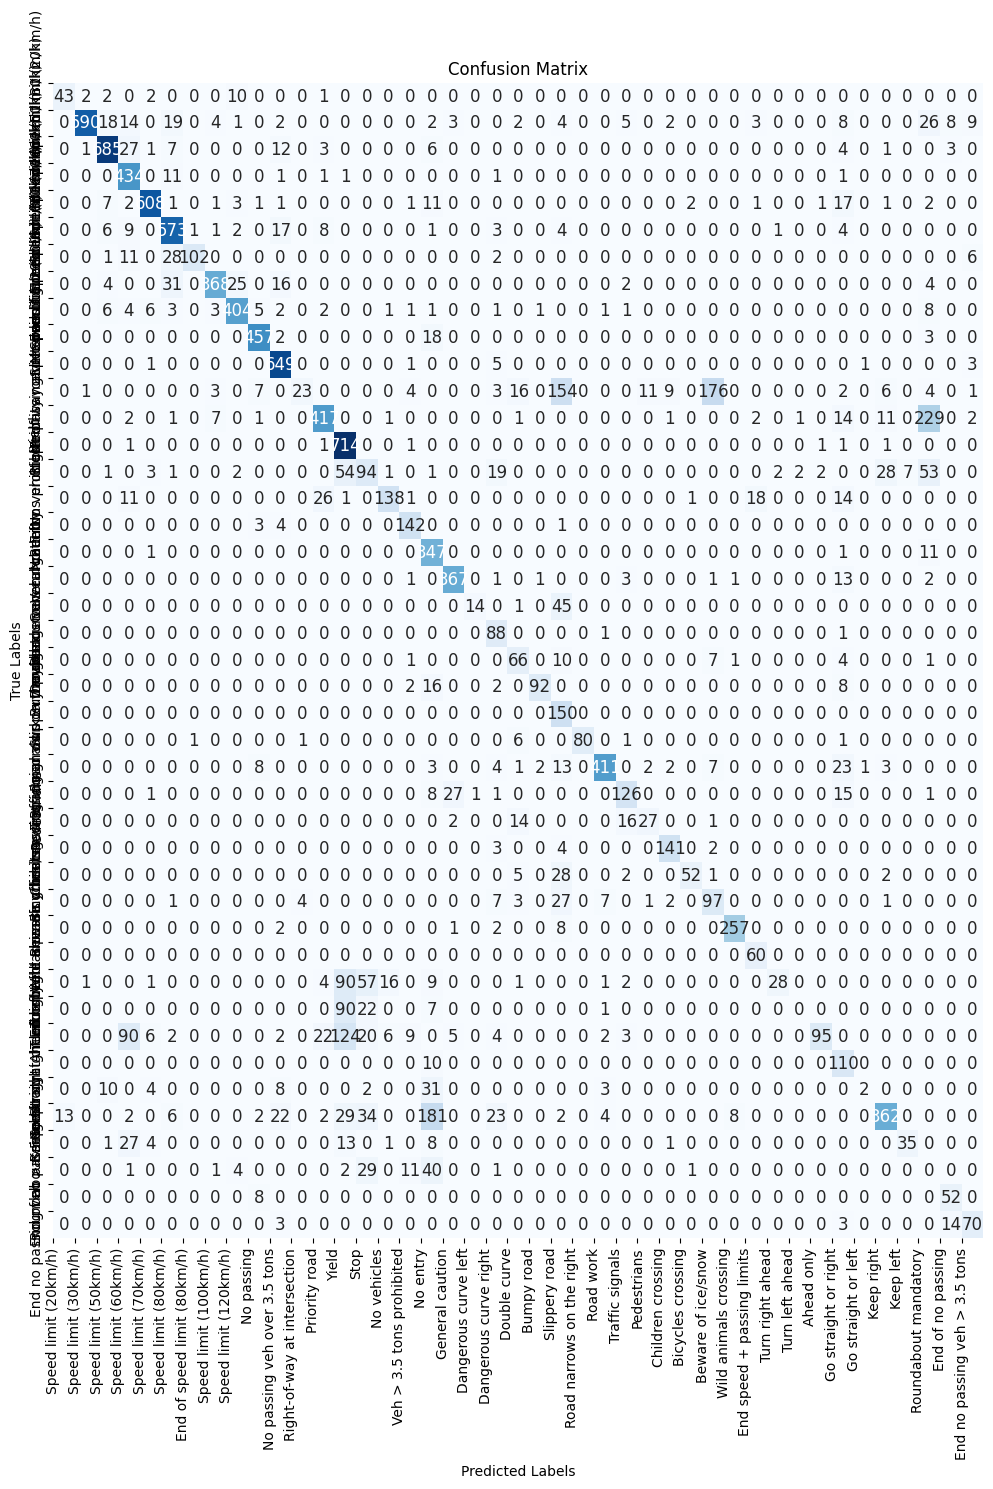

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(test_labels, pred)

# Plot confusion matrix
plt.figure(figsize=(12, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"fontsize": 12})  # Adjust the font size for the prediction numbers
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(len(classes)), classes.values(), rotation=90)
plt.yticks(np.arange(len(classes)), classes.values())
plt.show()

## **Insights from the Confusion Matrix**

*   The model performs well for frequent classes like
"Speed limit (50 km/h)" and "Priority road" because these classes have a larger number of samples in the GTSRB dataset, allowing the model to learn their features effectively.

*   Misclassifications occur between visually similar signs, such as "Speed limit (30 km/h)" and "Speed limit (50 km/h)." These signs often share similar shapes, colors, and patterns, which makes feature differentiation challenging for the model.

*   Rare classes like "End of speed limit" and "Slippery road" are misclassified more often because they are underrepresented in the dataset. The model has fewer examples to learn distinctive features for these signs, leading to poor generalization.

*  Improving performance for underrepresented classes requires addressing class imbalance through techniques like data augmentation or re-weighting the loss function. Additionally, more complex architectures like VGG16 could capture subtle differences in visually similar signs better, reducing misclassifications.





## **Model Predictions**

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


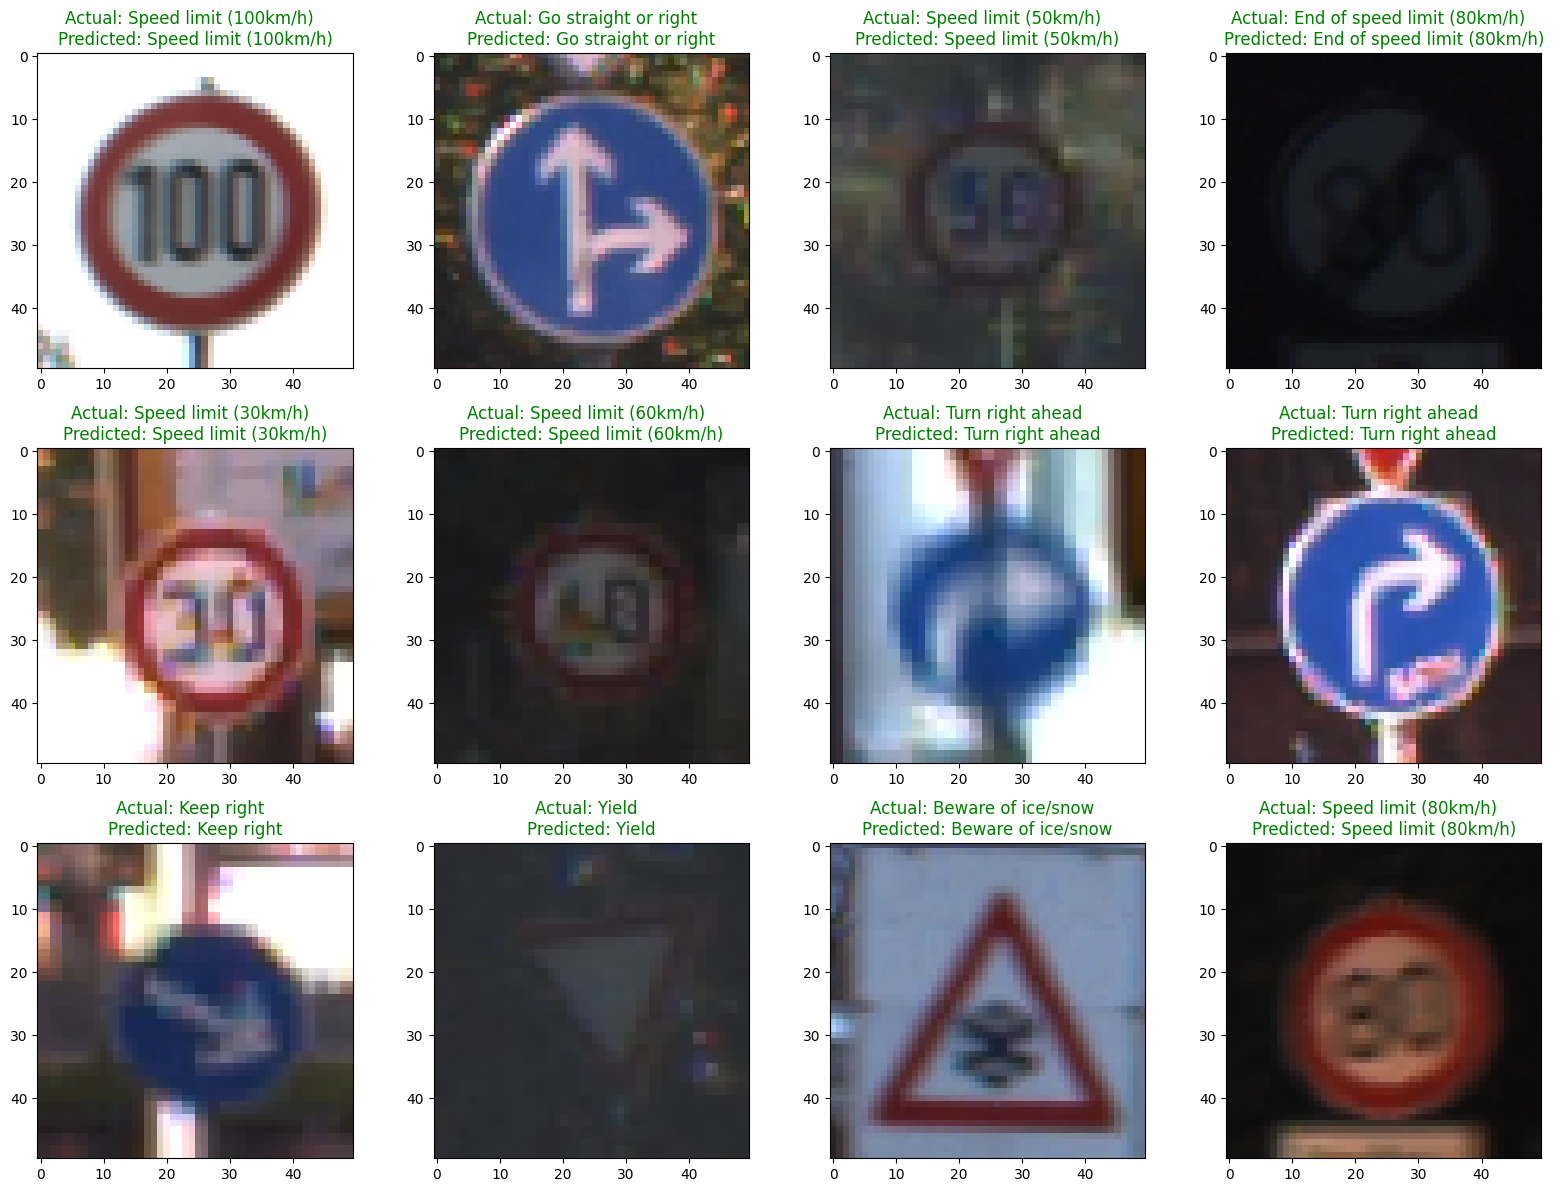

In [ ]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
val_images, val_labels = test_dataset[0]
predicted = model.predict(val_images)
predicts = map_pred(np.argmax(predicted, axis=-1))
labels = map_pred(np.argmax(val_labels, axis=-1))

for i in range(3):
    for j in range (4):
        idx=rn.randint(0,batch_size-1)
        ax[i,j].imshow(val_images[idx])
        if labels[idx] == predicts[idx]:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'green')
        else:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'red')

plt.tight_layout()

## **Building and Training the VGG16 Model**

## **Data Augmentation**


To improve the VGG16 model's robustness and generalization, we implemented data augmentation after observing the CNN model's limitations. Techniques like rotation, zoom, brightness adjustments, and shifting increased variability in the training data, helping the model handle real-world variations better. A 20% validation split ensured effective performance monitoring and reduced overfitting.

In [ ]:
#import the required Libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
import os

# Set a lower learning rate
alpha = 0.0001
optim = Adam(learning_rate=alpha)

# Load the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Fine-tune the base model
for layer in base_model.layers[:-10]:
    layer.trainable = False  # Freeze all layers except the last 10

# Add new layers on top of the base model
model2 = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.5),
    Dense(43, activation='softmax')  # 43 classes in the GTSRB dataset
])

# Compile the model
model2.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=False,
    validation_split=0.2  # Reserve 20% of training data for validation
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/GermanTrafficSigns/Train/',
    target_size=(50, 50),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Use 80% for training
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/GermanTrafficSigns/Train/',
    target_size=(50, 50),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Use 20% for validation
)

# Set up early stopping and model checkpointing
checkpoint_filepath = '/content/drive/MyDrive/GermanTrafficSigns/best_model.keras'
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True)

# Train the model
vgg_history = model2.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint]
)


Found 30385 images belonging to 43 classes.
Found 7592 images belonging to 43 classes.
Epoch 1/15
949/950 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.4288 - loss: 2.0861
Epoch 1: val_loss improved from inf to 0.84220, saving model to /content/drive/MyDrive/GermanTrafficSigns/best_model.keras
950/950 ━━━━━━━━━━━━━━━━━━━━ 140s 142ms/step - accuracy: 0.4293 - loss: 2.0844 - val_accuracy: 0.7587 - val_loss: 0.8422
Epoch 2/15
949/950 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8948 - loss: 0.3478
Epoch 2: val_loss improved from 0.84220 to 0.42870, saving model to /content/drive/MyDrive/GermanTrafficSigns/best_model.keras
950/950 ━━━━━━━━━━━━━━━━━━━━ 134s 140ms/step - accuracy: 0.8949 - loss: 0.3476 - val_accuracy: 0.8782 - val_loss: 0.4287
Epoch 3/15
949/950 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9502 - loss: 0.1786
Epoch 3: val_loss improved from 0.42870 to 0.40572, saving model to /content/drive/MyDrive/GermanTrafficSigns/best_model.keras
950/950 ━━━━━━━━━━━━━━━━━━━━ 1

## **Evaluating VGG16 Performance**

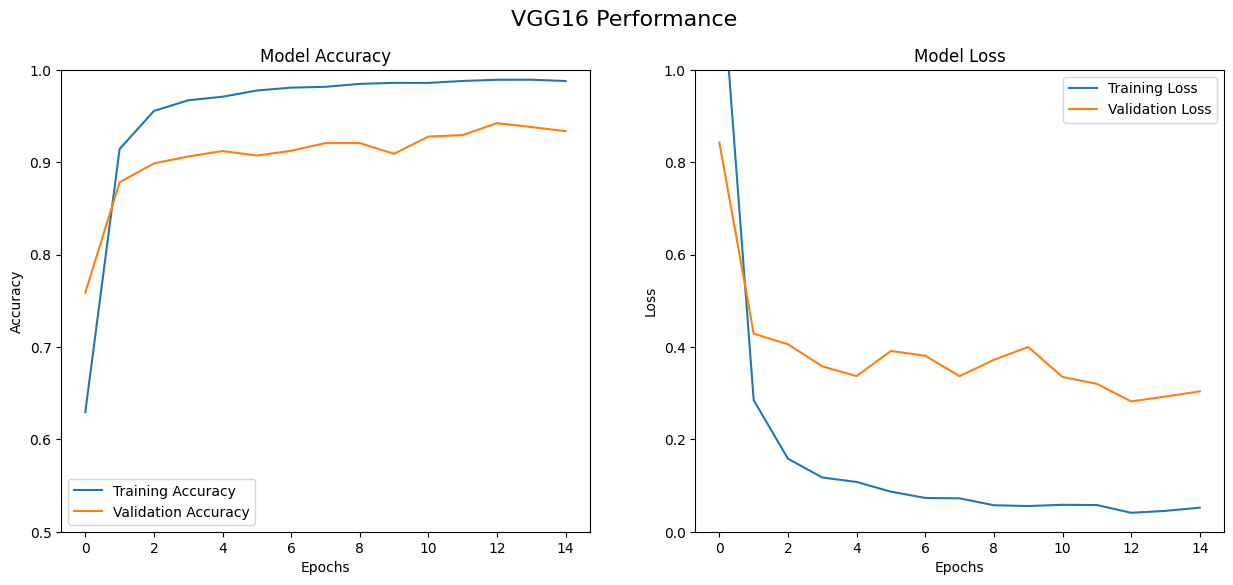

In [ ]:
#import required libraries
import matplotlib.pyplot as plt
import pandas as pd

# Convert the history to a DataFrame
performance = pd.DataFrame(vgg_history.history)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot Accuracy
ax[0].plot(performance[['accuracy', 'val_accuracy']])
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0.5, 1)  # Adjust y-axis range if needed

# Plot Loss
ax[1].plot(performance[['loss', 'val_loss']])
ax[1].legend(['Training Loss', 'Validation Loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_ylim(0, 1)  # Adjust y-axis range if needed

# Set a common title
fig.suptitle('VGG16 Performance', fontsize=16)

# Display the plots
plt.show()


The accuracy and loss graphs for the VGG16 model show consistent improvement in training and validation performance. Training accuracy quickly approaches near-perfect levels, while validation accuracy stabilizes around 94%, demonstrating the model's strong generalization. The gap between training and validation loss is minimal, indicating effective augmentation and mitigation of overfitting.








In [5]:
import cv2
import numpy as np
from PIL import Image

# Define height, width for resizing
height, width = 50, 50  # Match your model input size

# Path to the dataset
data_dir = '/content/drive/MyDrive/GermanTrafficSigns/'

# Load Test.csv
test_df = pd.read_csv(data_dir + 'Test.csv')

# Extract labels and image paths
test_labels = test_df["ClassId"].values
imgs = test_df["Path"].values

# Preprocess test images
data = []
for img in imgs:
    try:
        image = cv2.imread(data_dir + img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((height, width))
        data.append(np.array(resize_image))
    except Exception as e:
        print(f"Error in {img}: {e}")

X_test = np.array(data)
X_test = X_test / 255.0  # Normalize pixel values


In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# Generate predictions
pred = model2.predict(X_test)  # Predict probabilities for each class
pred = np.argmax(pred, axis=-1)  # Convert probabilities to class indices

# Map predicted indices to actual class labels
def map_pred(pred):
    return [int(list(train_generator.class_indices.keys())[i]) for i in pred]

mapped_pred = map_pred(pred)

# Calculate accuracy
accuracy = accuracy_score(test_labels, mapped_pred) * 100
print(f'Test Data Accuracy: {accuracy:.2f}%')


395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
Test Data Accuracy: 83.24%


## **Save the VGG16 Model**

In [ ]:
#save the model in .h5 format
model2.save("VGG_final.h5")

## **Model Predictions**

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


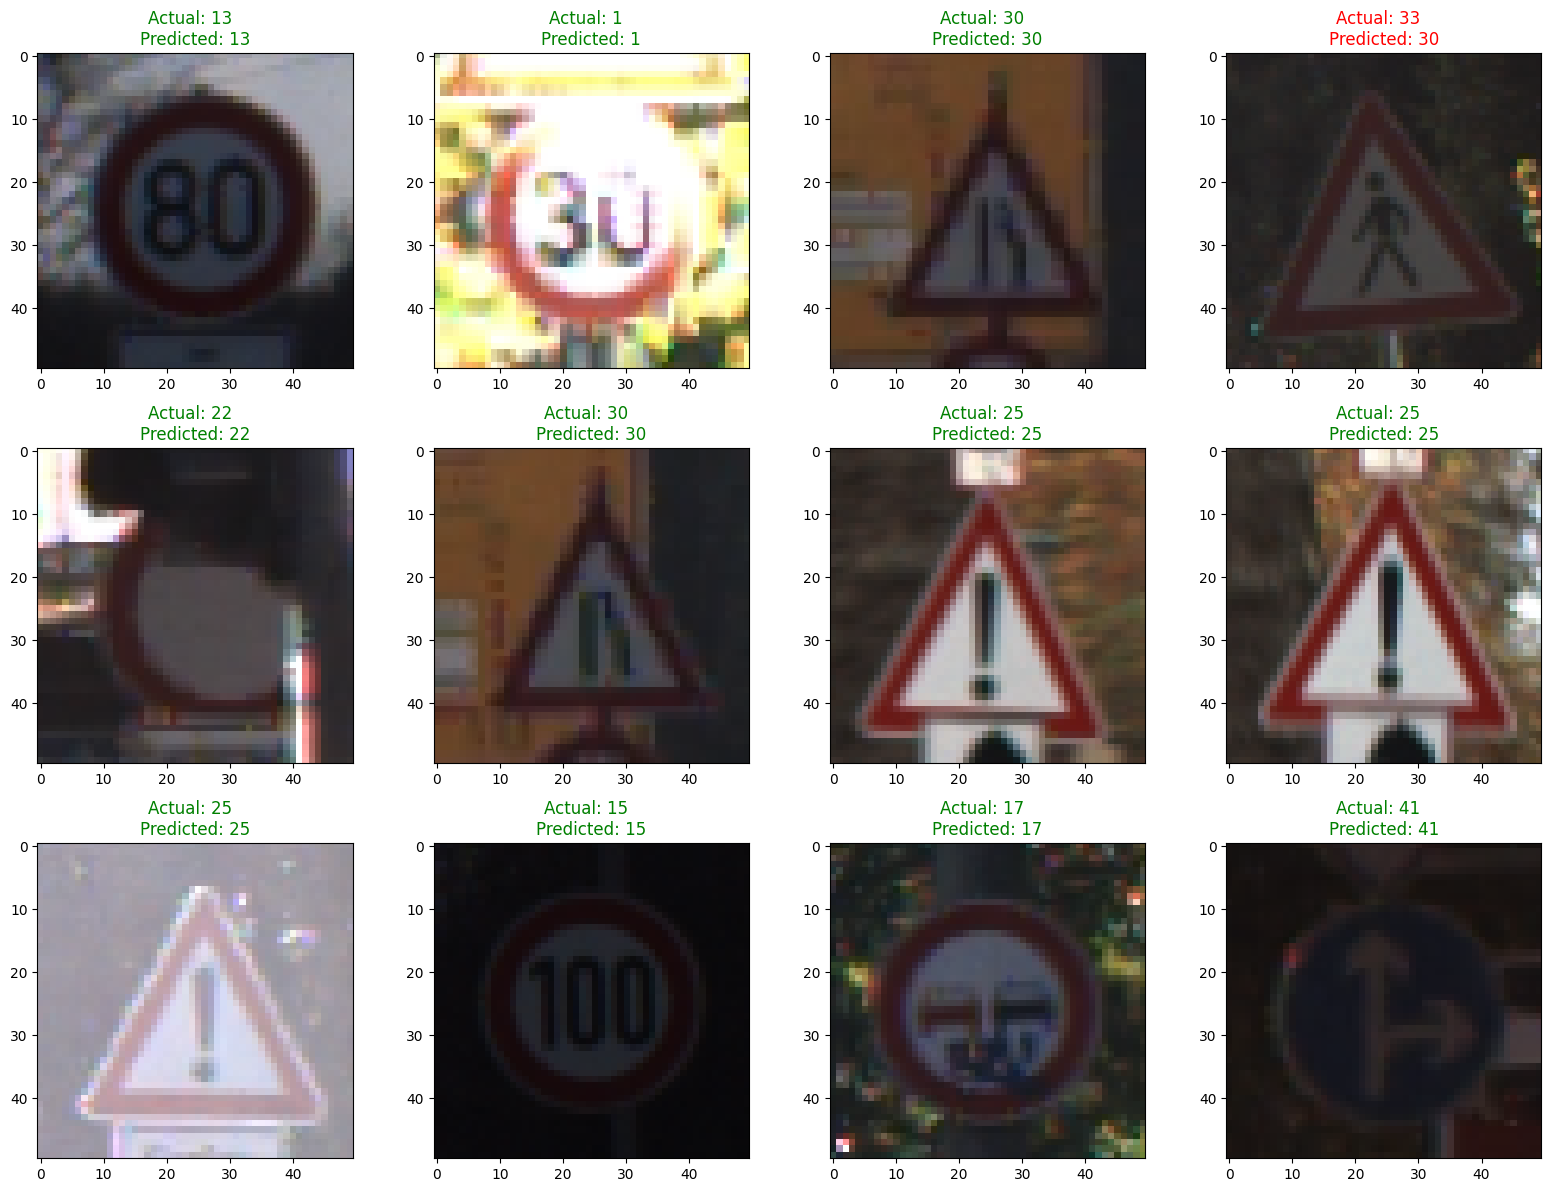

In [ ]:

fig, ax = plt.subplots(3, 4)
fig.set_size_inches(16, 12)

val_images, val_labels = test_dataset[0]
predicted = model2.predict(val_images)
predicts = map_pred(np.argmax(predicted, axis=-1))
labels = map_pred(np.argmax(val_labels, axis=-1))

for i in range(3):
    for j in range(4):
        idx = rn.randint(0, len(val_images) - 1)
        ax[i, j].imshow(val_images[idx])
        if labels[idx] == predicts[idx]:
            ax[i, j].set_title('Actual: ' + classes[labels[idx]] + '  \nPredicted: ' + classes[predicts[idx]], color='green')
        else:
            ax[i, j].set_title('Actual: ' + classes[labels[idx]] + '  \nPredicted: ' + classes[predicts[idx]], color='red')

plt.tight_layout()

## **Confusion Matrix**

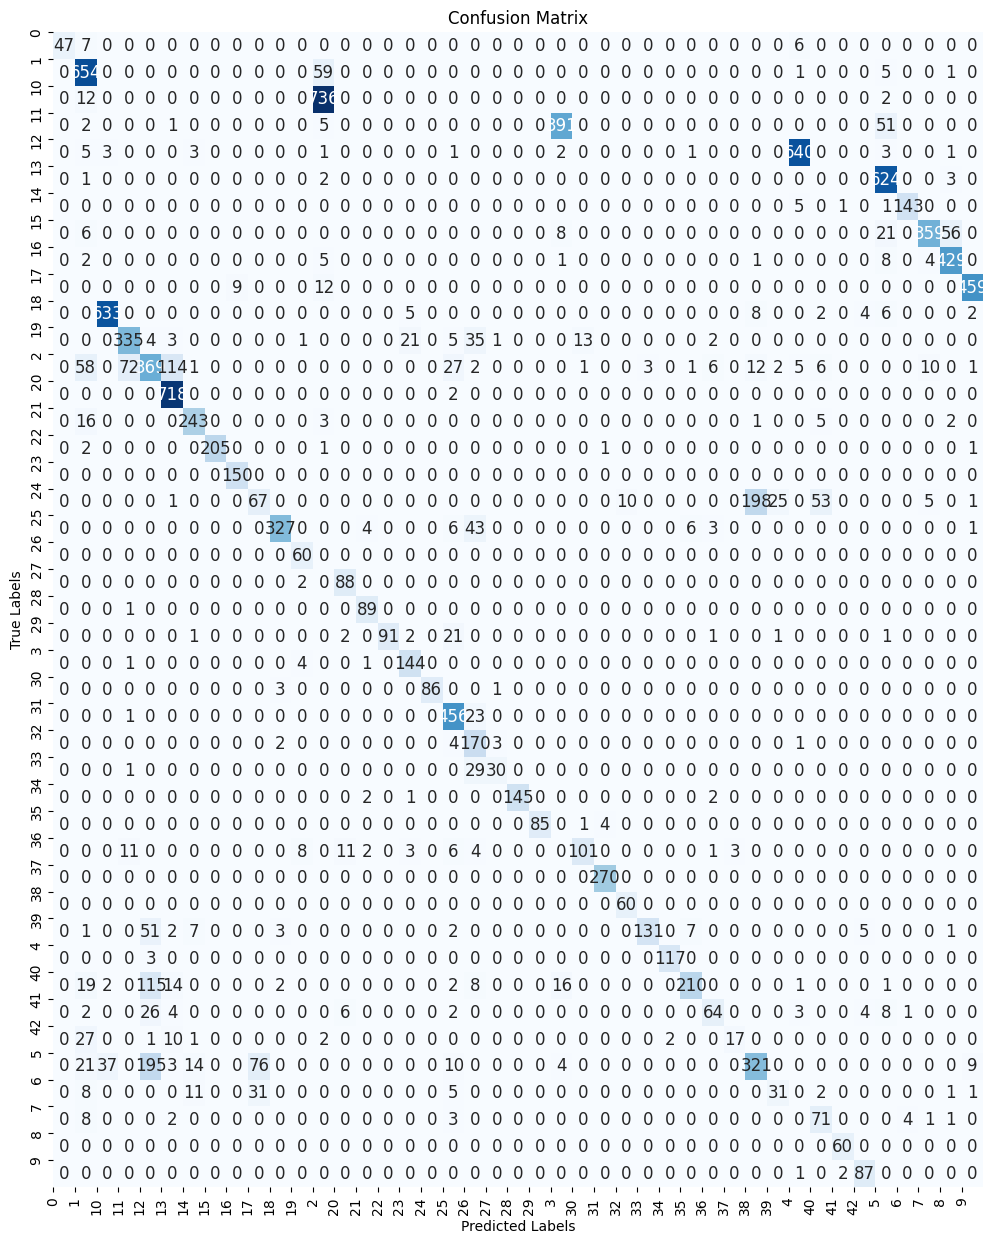

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(test_labels, pred)

# Plot confusion matrix
plt.figure(figsize=(12, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"fontsize": 12})  # Adjust the font size for the prediction numbers
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(len(classes)), classes.values(), rotation=90)
plt.yticks(np.arange(len(classes)), classes.values())
plt.show()


The VGG16 confusion matrix demonstrates improved class-wise predictions compared to the CNN model. The diagonal dominance indicates high accuracy in correctly predicting most traffic sign classes, with reduced misclassifications in closely related classes like speed limits and right-of-way signs. Unlike the CNN model, VGG16 achieves better separation for challenging classes, leveraging its deeper architecture and fine-tuning capabilities. However, minor misclassifications persist in visually similar or underrepresented classes, emphasizing the need for enhanced data augmentation or additional training for edge cases. Overall, VGG16 outperforms the custom CNN model in both accuracy and class-wise precision.

## **Conclusion**

## Best Model: VGG16

Higher Validation Accuracy:

VGG16 consistently achieves better validation accuracy compared to the custom CNN. This demonstrates its superior ability to generalize to unseen data, which is crucial for tasks like traffic sign classification.

Stable Performance:

The validation metrics (accuracy and loss) for VGG16 are more stable, showing fewer fluctuations compared to the custom CNN. This indicates a better generalization and robustness.

Pretrained Weights:

VGG16 utilizes pretrained weights from ImageNet, providing a strong foundation for feature extraction. This gives it an edge over the custom CNN, which starts learning from scratch.

Deeper Architecture:

The deeper architecture of VGG16 enables it to capture more complex patterns and hierarchies in the input data. This is particularly beneficial for a diverse dataset like GTSRB, which has 43 distinct classes.

Data Augmentation and Fine-Tuning:

When fine-tuned with data augmentation, VGG16 performs exceptionally well by leveraging both its pretrained features and additional data transformations, enhancing its adaptability to traffic sign images.

VGG16 is the better choice for this project due to its higher accuracy, stable performance, and superior generalization capabilities, making it ideal for deployment in real-world traffic sign recognition systems. However, for resource-constrained environments, the custom CNN remains a viable option